In [1]:
from watclaimdata import test_df,train_df,valid_df

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

2023-11-05 13:49:29.927082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df.tail()

,claim,id,rating,original_rating
26971,"If an individual is determined ""to commit suic...",26972,1,barely-true
26972,Former NBA star said modern basketball players...,26973,0,false
26973,"""Since Debbie Halvorson has been in politics, ...",26974,1,half-true
26974,"President Barack Obama ""had the legal authorit...",26975,2,true
26975,Photograph of a Congress worker protesting aga...,26976,0,false


<AxesSubplot:>

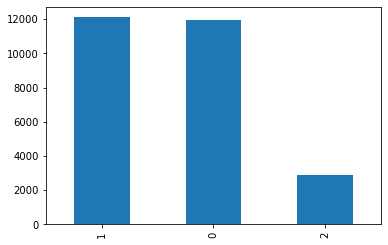

In [3]:
train_df['rating'].value_counts().plot(kind='bar')

In [4]:
# check version number
import imblearn
print(imblearn.__version__)

0.9.0


NearMiss-3 selects the closest examples from the majority class for each minority class.

The n_neighbors_ver3 argument determines the number of examples to select for each minority example, although the desired balancing ratio set via sampling_strategy will filter this to achieve the desired balance.

In [5]:
X = train_df.iloc[:,1:2]
X.shape

(26976, 1)

In [6]:
y = train_df['rating']
y.shape

(26976,)

In [7]:
valid_df['indx'] = valid_df.index

In [8]:
valid_df.head()

,claim,id,rating,original_rating,indx
0,"Video shows that ""Joe Biden participated in 'B...",26977,0,false,0
1,"""While Act 10 allowed (Milwaukee County) to sa...",26978,1,half-true,1
2,"""In Massachusetts, Biden’s vote exceeded exit ...",26979,0,false,2
3,Reliance supplying Jio Atta after farm bills w...,26980,0,false,3
4,Photo of maulvi and MP Shafiqur Rahman Virk pe...,26981,0,false,4


In [9]:
X_v = valid_df[['indx']]
y_v = valid_df['rating']
X_v.shape

(3372, 1)

In [10]:
# define the undersampling method
# undersample = NearMiss(version=3)

from imblearn.over_sampling import SMOTE


# define the undersampling method
oversample = SMOTE()
# transform the dataset
X_over, y_over = oversample.fit_resample(X, y.ravel())
Xv_over, yv_over = oversample.fit_resample(X_v, y_v.ravel())

from imblearn.under_sampling import NearMiss


# define the undersampling method
undersample = NearMiss(n_neighbors_ver3=3)
# transform the dataset
X_near, y_near = undersample.fit_resample(X, y.ravel())
Xv_near, yv_near = undersample.fit_resample(X_v, y_v.ravel())


In [11]:
print("After Oversampling, counts of label '1': {}".format(sum(y_over == 1))) 
print("After Oversampling, counts of label '0': {}".format(sum(y_over == 0))) 
print("After Oversampling, counts of label '2': {}".format(sum(y_over == 2))) 

print("After Undersampling, counts of label '1': {}".format(sum(y_near == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_near == 0))) 
print("After Undersampling, counts of label '2': {}".format(sum(y_near == 2))) 

After Oversampling, counts of label '1': 12105
After Oversampling, counts of label '0': 12105
After Oversampling, counts of label '2': 12105
After Undersampling, counts of label '1': 2894
After Undersampling, counts of label '0': 2894
After Undersampling, counts of label '2': 2894


In [12]:
over_idx = X_over['id'].apply(lambda x: x-1).tolist()
train_over_df = train_df.loc[over_idx]

over_v_idx = Xv_over['indx'].tolist()
valid_over_df = valid_df.loc[over_v_idx]

In [13]:
near_idx = X_near['id'].apply(lambda x: x-1).tolist()
train_near_df = train_df.loc[near_idx]

near_v_idx = Xv_near['indx'].tolist()
valid_near_df = valid_df.loc[near_v_idx]

In [14]:
train_near_df['rating'].unique()

array([0, 1, 2])

In [15]:
train_near_df[train_near_df['rating'] == 0][:5]

,claim,id,rating,original_rating
40,Indians in Spain celebrating Ram Mandir constr...,41,0,false
419,"Says ""Nancy Pelosi came out in favor of MS-13.""",420,0,false
874,Muslims punished for breaking lockdown in India,875,0,false
1629,Photo of Narendra Modi's mother in an auto-ric...,1630,0,false
1705,"President Donald Trump’s budget ""threatened to...",1706,0,false


In [16]:
train_near_df[train_near_df['rating'] == 1][:5]

,claim,id,rating,original_rating
1008,"The number of people who ""believe in socialism...",1009,1,half-true
6412,An image shows animals burning in the Australi...,6413,1,barely-true
7457,"Donald Trump would ""engage in a risky scheme t...",7458,1,barely-true
7635,A photograph shows a nude man walking the runw...,7636,1,miscaptioned
8675,Anyone bringing supplies to DAPL protesters at...,8676,1,mostly true


In [17]:
train_near_df[train_near_df['rating'] == 2][:5]

,claim,id,rating,original_rating
13,"Says that U.S. Rep. Allen West is ""a constitue...",14,2,true
14,"""The average margin of victory in the House of...",15,2,true
25,"""Not a single Democrat opposed Neil Gorsuch's ...",26,2,true
28,"Ted Livingston, the CEO of Kik Interactive, an...",29,2,true
31,There are cities and counties in Georgia that ...,32,2,true


In [18]:
train_df['new_rating'] = np.where(train_df['rating'] == 0,'false',np.where(train_df['rating'] == 1,'misleading',np.where(train_df['rating'] == 2,'true','')))
train_df['new_rating'].unique()

# test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_df['new_rating'] = np.where(valid_df['rating'] == 0,'false',np.where(valid_df['rating'] == 1,'misleading',np.where(valid_df['rating'] == 2,'true','')))



In [19]:
train_over_df['new_rating'] = np.where(train_over_df['rating'] == 0,'false',np.where(train_over_df['rating'] == 1,'misleading',np.where(train_over_df['rating'] == 2,'true','')))
train_over_df['new_rating'].unique()

test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_over_df['new_rating'] = np.where(valid_over_df['rating'] == 0,'false',np.where(valid_over_df['rating'] == 1,'misleading',np.where(valid_over_df['rating'] == 2,'true','')))



In [20]:
train_near_df['new_rating'] = np.where(train_near_df['rating'] == 0,'false',np.where(train_near_df['rating'] == 1,'misleading',np.where(train_near_df['rating'] == 2,'true','')))
train_near_df['new_rating'].unique()

# test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_near_df['new_rating'] = np.where(valid_near_df['rating'] == 0,'false',np.where(valid_near_df['rating'] == 1,'misleading',np.where(valid_near_df['rating'] == 2,'true','')))



In [21]:

dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_train_over_y = np.array(pd.get_dummies(train_over_df['new_rating']))
dummy_train_near_y = np.array(pd.get_dummies(train_near_df['new_rating']))


dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))

dummy_valid_y = np.array(pd.get_dummies(valid_df['new_rating']))
dummy_valid_near_y = np.array(pd.get_dummies(valid_near_df['new_rating']))
dummy_valid_over_y = np.array(pd.get_dummies(valid_over_df['new_rating']))


In [22]:
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

EMBEDDING_DIM = len(model['university'])      

# initialize embedding matrix and word-to-id map:  
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))  
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [23]:
train_near_df['claim'].values.tolist()[:4]

['Indians in Spain celebrating Ram Mandir construction',
 'Says "Nancy Pelosi came out in favor of MS-13."',
 'Muslims punished for breaking lockdown in India',
 "Photo of Narendra Modi's mother in an auto-rickshaw is photoshopped"]

In [24]:
np.array(train_near_df['rating'].values.tolist())[:4]

array([0, 0, 0, 0])

In [98]:
train_examples = train_df['claim'].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())

train_over_examples = train_over_df['claim'].values.tolist()
train_over_examples = tf.convert_to_tensor(train_over_examples)
train_over_labels = np.array(train_over_df['rating'].values.tolist())

train_near_examples = train_near_df['claim'].values.tolist()
train_near_examples = tf.convert_to_tensor(train_near_examples)
train_near_labels = np.array(train_near_df['rating'].values.tolist())


test_examples = test_df['claim'].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())




val_examples = valid_df['claim'].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(valid_df['rating'].values.tolist())

val_over_examples = valid_over_df['claim'].values.tolist()
val_over_examples = tf.convert_to_tensor(val_over_examples)
val_over_labels = np.array(valid_over_df['rating'].values.tolist())

val_near_examples = valid_near_df['claim'].values.tolist()
val_near_examples = tf.convert_to_tensor(val_near_examples)
val_near_labels = np.array(valid_near_df['rating'].values.tolist())

# print('Train data contains {} with labels of {}'.format(train_examples.shape[0],train_labels['rating'].unique()))

NameError: name 'test_over_df' is not defined

In [26]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
       b'\xe2\x80\x9c38,000 prisoners were released from federal prison\xe2\x80\x9d during the Obama administration.',
       b'Says\xc2\xa0Wisconsin \xe2\x80\x98could compel\xe2\x80\x99 Foxconn to install solar panels that would power 33,000 homes.',
       b"A 4-year-old boy was accused of hacking the FBI's databases."],
      dtype=object)>

In [27]:
train_labels[:4]

array([0, 1, 1, 0])

In [28]:
train_labels.shape

(26976,)

In [29]:
# tf.convert_to_tensor(train_examples)

In [30]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(val_examples)

tokenizer = tf_text.WhitespaceTokenizer()
train_over_tokens = tokenizer.tokenize(train_over_examples)
test_over_tokens = tokenizer.tokenize(val_over_examples)

tokenizer = tf_text.WhitespaceTokenizer()
train_near_tokens = tokenizer.tokenize(train_near_examples)
test_near_tokens = tokenizer.tokenize(val_near_examples)

In [31]:
train_tokens[0]

<tf.Tensor: shape=(9,), dtype=string, numpy=
array([b'OpIndia', b'claimed', b'Greta', b"Thunberg's", b'real', b'name',
       b'is', b'Ghazala', b'bhat'], dtype=object)>

In [32]:
MAX_SEQUENCE_LENGTH = 128

def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [96]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(val_labels)
t_test_labels = np.array(test_labels)

In [34]:
train_over_input = docs_to_vocab_ids(train_over_tokens)
test_over_input = docs_to_vocab_ids(test_over_tokens)

train_over_labels = np.array(train_over_labels)
test_over_labels = np.array(val_over_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Total examples:  36314
Examples processed:  0
Total examples:  4547


In [35]:
train_near_input = docs_to_vocab_ids(train_near_tokens)
test_near_input = docs_to_vocab_ids(test_near_tokens)

train_near_labels = np.array(train_near_labels)
test_near_labels = np.array(val_near_labels)

Examples processed:  0
Examples processed:  5000
Total examples:  8681
Examples processed:  0
Total examples:  1079


In [36]:
# train_input[:4]

In [37]:
train_labels[:4]

array([0, 1, 1, 0])

In [38]:
def build_ann_model(num_classes, embeddings_trainable=False):
    an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    
    an_embedding_layer = Embedding(embedding_matrix.shape[0],
                                   embedding_matrix.shape[1],
                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                   input_length=MAX_SEQUENCE_LENGTH,
                                   trainable=embeddings_trainable)
    
    an_embeddings = an_embedding_layer(an_input_layer)
    
    an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)
    
    an_classification = tf.keras.layers.Dense(num_classes, 
                                              activation='softmax', 
                                              name='an_classification')(an_avg_embeddings)
    
    an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])
    
    
    an_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                     metrics='accuracy')
    return an_model

In [39]:
ann_model = build_ann_model(3)
ann_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 3)                 903       
                                                                 
Total params: 13195503 (50.34 MB)
Trainable params: 903 (3.53 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________


In [40]:
ann_history = ann_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
843/843 [==============================] - 3s 3ms/step - loss: 0.9992 - accuracy: 0.5311 - val_loss: 0.9596 - val_accuracy: 0.5246
Epoch 2/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9510 - accuracy: 0.5522 - val_loss: 0.9455 - val_accuracy: 0.5486
Epoch 3/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9411 - accuracy: 0.5538 - val_loss: 0.9391 - val_accuracy: 0.5516
Epoch 4/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9347 - accuracy: 0.5544 - val_loss: 0.9346 - val_accuracy: 0.5504
Epoch 5/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9298 - accuracy: 0.5570 - val_loss: 0.9310 - val_accuracy: 0.5477
Epoch 6/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9259 - accuracy: 0.5578 - val_loss: 0.9282 - val_accuracy: 0.5495
Epoch 7/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9226 - accuracy: 0.5587 - val_loss: 0.9262 - val_accuracy: 0.5525
Epoch 

In [92]:
ann_score = ann_model.evaluate(train_input,dummy_train_y)
print("%s: %.2f%%" % (ann_model.metrics_names[1], ann_score[1]*100))

843/843 [==============================] - 2s 2ms/step - loss: 1.0219 - accuracy: 0.5143
accuracy: 51.43%


In [97]:
from sklearn.metrics import classification_report

y_pred = ann_model.predict(test_input, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(t_test_labels, y_pred_bool))

53/53 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      1516
           1       0.57      0.36      0.44      1496
           2       0.17      0.37      0.23       360

    accuracy                           0.49      3372
   macro avg       0.44      0.46      0.43      3372
weighted avg       0.54      0.49      0.50      3372



In [41]:
ann_over_history = ann_model.fit(train_over_input,
                          dummy_train_over_y,
                          validation_data=(test_over_input, dummy_valid_over_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9437 - accuracy: 0.5530 - val_loss: 0.9591 - val_accuracy: 0.5431
Epoch 2/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9419 - accuracy: 0.5546 - val_loss: 0.9582 - val_accuracy: 0.5424
Epoch 3/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.9408 - accuracy: 0.5538 - val_loss: 0.9577 - val_accuracy: 0.5446
Epoch 4/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.9399 - accuracy: 0.5547 - val_loss: 0.9568 - val_accuracy: 0.5411
Epoch 5/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9389 - accuracy: 0.5554 - val_loss: 0.9561 - val_accuracy: 0.5405
Epoch 6/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9380 - accuracy: 0.5559 - val_loss: 0.9556 - val_accuracy: 0.5446
Epoch 7/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.9373 - accuracy: 0.5572 - val_loss: 0.9550 - val_accuracy:

In [42]:
ann_near_history = ann_model.fit(train_near_input,
                          dummy_train_near_y,
                          validation_data=(test_near_input, dummy_valid_near_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0752 - accuracy: 0.4440 - val_loss: 1.0580 - val_accuracy: 0.4417
Epoch 2/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0319 - accuracy: 0.4648 - val_loss: 1.0484 - val_accuracy: 0.4343
Epoch 3/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0282 - accuracy: 0.4726 - val_loss: 1.0474 - val_accuracy: 0.4454
Epoch 4/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0277 - accuracy: 0.4756 - val_loss: 1.0469 - val_accuracy: 0.4426
Epoch 5/20
272/272 [==============================] - 1s 3ms/step - loss: 1.0272 - accuracy: 0.4773 - val_loss: 1.0465 - val_accuracy: 0.4444
Epoch 6/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0269 - accuracy: 0.4792 - val_loss: 1.0460 - val_accuracy: 0.4444
Epoch 7/20
272/272 [==============================] - 1s 2ms/step - loss: 1.0266 - accuracy: 0.4796 - val_loss: 1.0456 - val_accuracy: 0.4435
Epoch 

In [43]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_history3,
              model_1_name='model 1',
              model_2_name='model 2',
              model_3_name='model 3',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2, model_history3]):
            model_name = [model_1_name, model_2_name, model_3_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

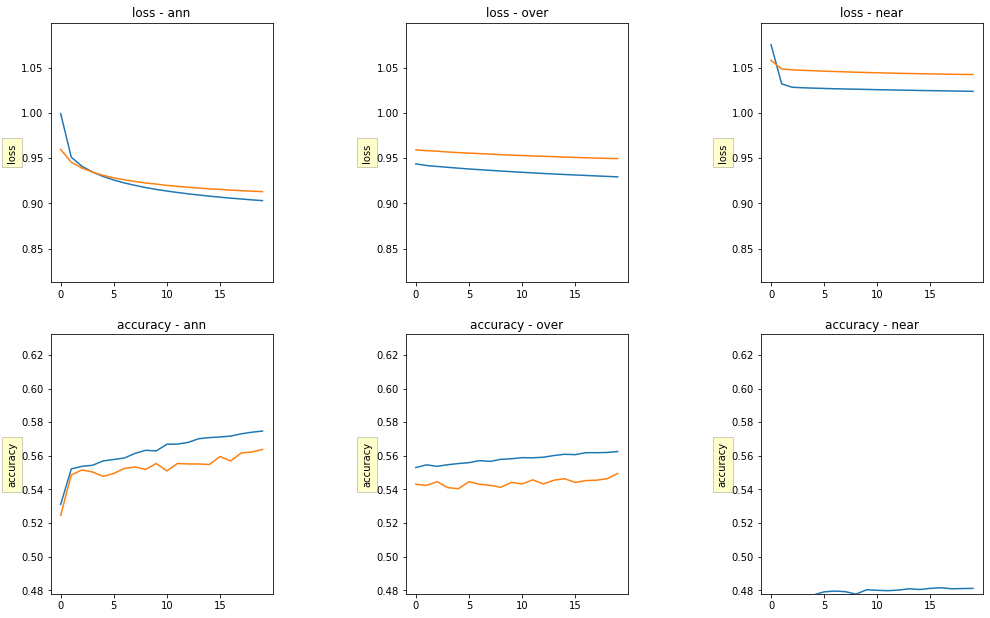

In [49]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          ann_history,
          ann_over_history,
          ann_near_history,
          model_1_name='ann',
          model_2_name='over',
          model_3_name='near')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [50]:
def build_dan_model(num_classes, hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)
    
    dan_classification = tf.keras.layers.Dense(3,
                                               activation='softmax',
                                               name='dan_classification')(last_hidden_output)
    
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

python(91816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


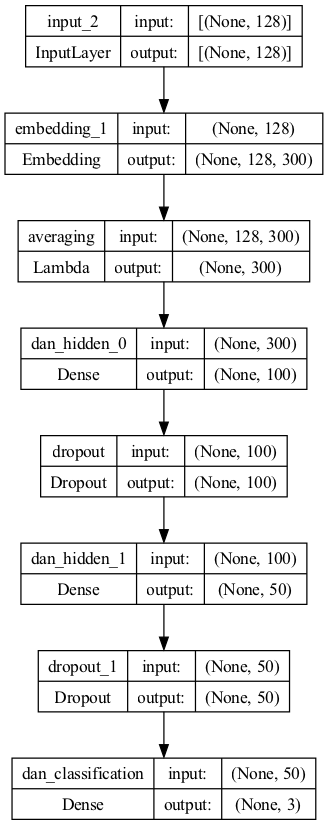

In [51]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5
num_classes = 3

dan_model = build_dan_model(num_classes, hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [52]:
dan_history = dan_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=20
                            )

Epoch 1/20
843/843 [==============================] - 3s 3ms/step - loss: 0.9513 - accuracy: 0.5116 - val_loss: 0.9160 - val_accuracy: 0.5552
Epoch 2/20
843/843 [==============================] - 2s 3ms/step - loss: 0.9085 - accuracy: 0.5682 - val_loss: 0.9021 - val_accuracy: 0.5676
Epoch 3/20
843/843 [==============================] - 2s 3ms/step - loss: 0.8952 - accuracy: 0.5834 - val_loss: 0.8987 - val_accuracy: 0.5626
Epoch 4/20
843/843 [==============================] - 2s 2ms/step - loss: 0.8872 - accuracy: 0.5839 - val_loss: 0.8903 - val_accuracy: 0.5730
Epoch 5/20
843/843 [==============================] - 2s 3ms/step - loss: 0.8813 - accuracy: 0.5889 - val_loss: 0.8874 - val_accuracy: 0.5777
Epoch 6/20
843/843 [==============================] - 2s 3ms/step - loss: 0.8789 - accuracy: 0.5889 - val_loss: 0.8843 - val_accuracy: 0.5741
Epoch 7/20
843/843 [==============================] - 2s 3ms/step - loss: 0.8755 - accuracy: 0.5907 - val_loss: 0.8855 - val_accuracy: 0.5750
Epoch 

In [99]:
dan_score = dan_model.evaluate(train_input,dummy_train_y)
print("%s: %.2f%%" % (dan_model.metrics_names[1], dan_score[1]*100))

y_pred = dan_model.predict(test_input, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(t_test_labels, y_pred_bool))

843/843 [==============================] - 2s 2ms/step - loss: 0.8999 - accuracy: 0.5615
accuracy: 56.15%
53/53 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1516
           1       0.56      0.47      0.51      1496
           2       0.19      0.45      0.27       360

    accuracy                           0.50      3372
   macro avg       0.46      0.49      0.45      3372
weighted avg       0.56      0.50      0.52      3372



In [53]:
dan_over_history = dan_model.fit(train_over_input,
                          dummy_train_over_y,
                          validation_data=(test_over_input, dummy_valid_over_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8977 - accuracy: 0.5798 - val_loss: 0.9218 - val_accuracy: 0.5613
Epoch 2/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8958 - accuracy: 0.5799 - val_loss: 0.9233 - val_accuracy: 0.5607
Epoch 3/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8929 - accuracy: 0.5805 - val_loss: 0.9209 - val_accuracy: 0.5609
Epoch 4/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8927 - accuracy: 0.5798 - val_loss: 0.9205 - val_accuracy: 0.5605
Epoch 5/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8921 - accuracy: 0.5805 - val_loss: 0.9226 - val_accuracy: 0.5583
Epoch 6/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8892 - accuracy: 0.5801 - val_loss: 0.9224 - val_accuracy: 0.5635
Epoch 7/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.8895 - accuracy: 0.5835 - val_loss: 0.9228 - val_accuracy:

In [54]:
dan_near_history = dan_model.fit(train_near_input,
                          dummy_train_near_y,
                          validation_data=(test_near_input, dummy_valid_near_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9718 - accuracy: 0.5036 - val_loss: 1.0024 - val_accuracy: 0.4963
Epoch 2/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9561 - accuracy: 0.5299 - val_loss: 0.9987 - val_accuracy: 0.5065
Epoch 3/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9594 - accuracy: 0.5328 - val_loss: 0.9911 - val_accuracy: 0.5019
Epoch 4/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9470 - accuracy: 0.5392 - val_loss: 0.9925 - val_accuracy: 0.5046
Epoch 5/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9461 - accuracy: 0.5461 - val_loss: 0.9960 - val_accuracy: 0.5019
Epoch 6/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9487 - accuracy: 0.5422 - val_loss: 0.9934 - val_accuracy: 0.5130
Epoch 7/20
272/272 [==============================] - 1s 3ms/step - loss: 0.9406 - accuracy: 0.5431 - val_loss: 1.0149 - val_accuracy: 0.4963
Epoch 

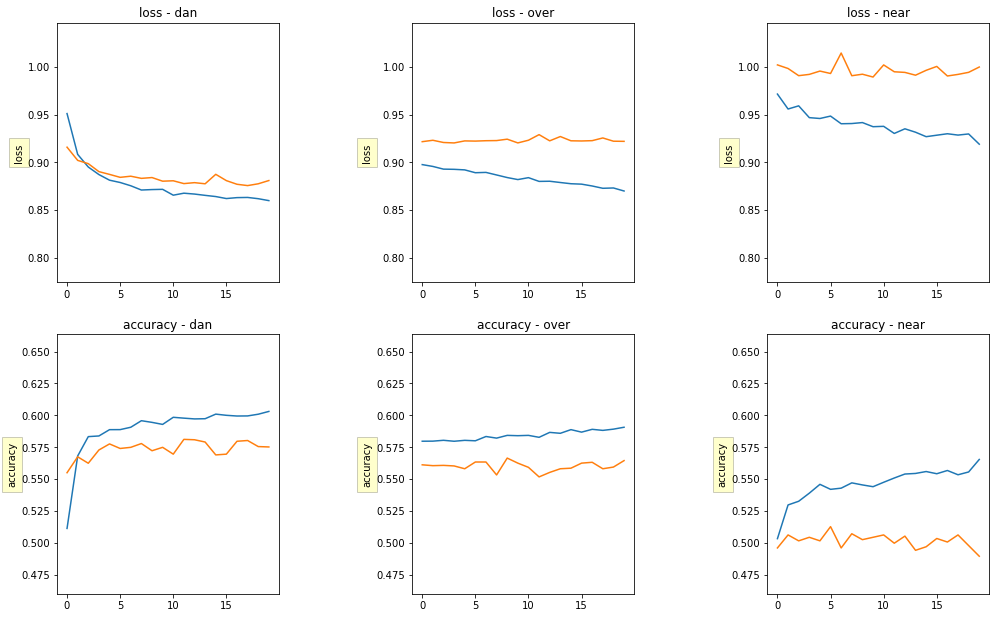

In [55]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          dan_over_history,
          dan_near_history,
          model_1_name='dan',
          model_2_name='over',
          model_3_name='near')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# CNN

In [56]:
def build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [57]:
# Now specify model hyperparameters and call the function to create a CNN model

num_classes = 3
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [58]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 128, 300)             1319460   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 126, 100)             90100     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 100)             120100    ['embedding_2[0][0]']   

In [59]:
cnn_history = cnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
843/843 [==============================] - 60s 70ms/step - loss: 0.8996 - accuracy: 0.5722 - val_loss: 0.8864 - val_accuracy: 0.5727
Epoch 2/5
843/843 [==============================] - 56s 67ms/step - loss: 0.8497 - accuracy: 0.6085 - val_loss: 0.8742 - val_accuracy: 0.5827
Epoch 3/5
843/843 [==============================] - 59s 70ms/step - loss: 0.8125 - accuracy: 0.6241 - val_loss: 0.8729 - val_accuracy: 0.5824
Epoch 4/5
843/843 [==============================] - 57s 68ms/step - loss: 0.7643 - accuracy: 0.6498 - val_loss: 0.8868 - val_accuracy: 0.5931
Epoch 5/5
843/843 [==============================] - 55s 65ms/step - loss: 0.7122 - accuracy: 0.6812 - val_loss: 0.8974 - val_accuracy: 0.5875


In [100]:
cnn_score = cnn_model.evaluate(train_input,dummy_train_y)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], cnn_score[1]*100))

y_pred = cnn_model.predict(test_input, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(t_test_labels, y_pred_bool))

843/843 [==============================] - 13s 15ms/step - loss: 0.1060 - accuracy: 0.9634
accuracy: 96.34%
53/53 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.63      0.53      0.58      1516
           1       0.56      0.59      0.57      1496
           2       0.22      0.30      0.25       360

    accuracy                           0.53      3372
   macro avg       0.47      0.47      0.47      3372
weighted avg       0.55      0.53      0.54      3372



In [62]:
cnn_over_history = cnn_model.fit(train_over_input,
                          dummy_train_over_y,
                          validation_data=(test_over_input, dummy_valid_over_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
1135/1135 [==============================] - 79s 69ms/step - loss: 0.2822 - accuracy: 0.8898 - val_loss: 1.3135 - val_accuracy: 0.5550
Epoch 2/5
1135/1135 [==============================] - 73s 64ms/step - loss: 0.2691 - accuracy: 0.8939 - val_loss: 1.4056 - val_accuracy: 0.5460
Epoch 3/5
1135/1135 [==============================] - 77s 68ms/step - loss: 0.2511 - accuracy: 0.9015 - val_loss: 1.4299 - val_accuracy: 0.5466
Epoch 4/5
1135/1135 [==============================] - 79s 70ms/step - loss: 0.2452 - accuracy: 0.9055 - val_loss: 1.4133 - val_accuracy: 0.5365
Epoch 5/5
1135/1135 [==============================] - 81s 71ms/step - loss: 0.2299 - accuracy: 0.9113 - val_loss: 1.5060 - val_accuracy: 0.5413


In [63]:
cnn_near_history = cnn_model.fit(train_near_input,
                          dummy_train_near_y,
                          validation_data=(test_near_input, dummy_valid_near_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
272/272 [==============================] - 19s 68ms/step - loss: 0.2177 - accuracy: 0.9155 - val_loss: 1.8207 - val_accuracy: 0.4639
Epoch 2/5
272/272 [==============================] - 20s 74ms/step - loss: 0.1823 - accuracy: 0.9304 - val_loss: 1.8472 - val_accuracy: 0.4648
Epoch 3/5
272/272 [==============================] - 18s 66ms/step - loss: 0.1617 - accuracy: 0.9386 - val_loss: 1.9336 - val_accuracy: 0.4750
Epoch 4/5
272/272 [==============================] - 20s 74ms/step - loss: 0.1503 - accuracy: 0.9430 - val_loss: 1.7673 - val_accuracy: 0.4704
Epoch 5/5
272/272 [==============================] - 19s 72ms/step - loss: 0.1393 - accuracy: 0.9479 - val_loss: 1.9025 - val_accuracy: 0.4778


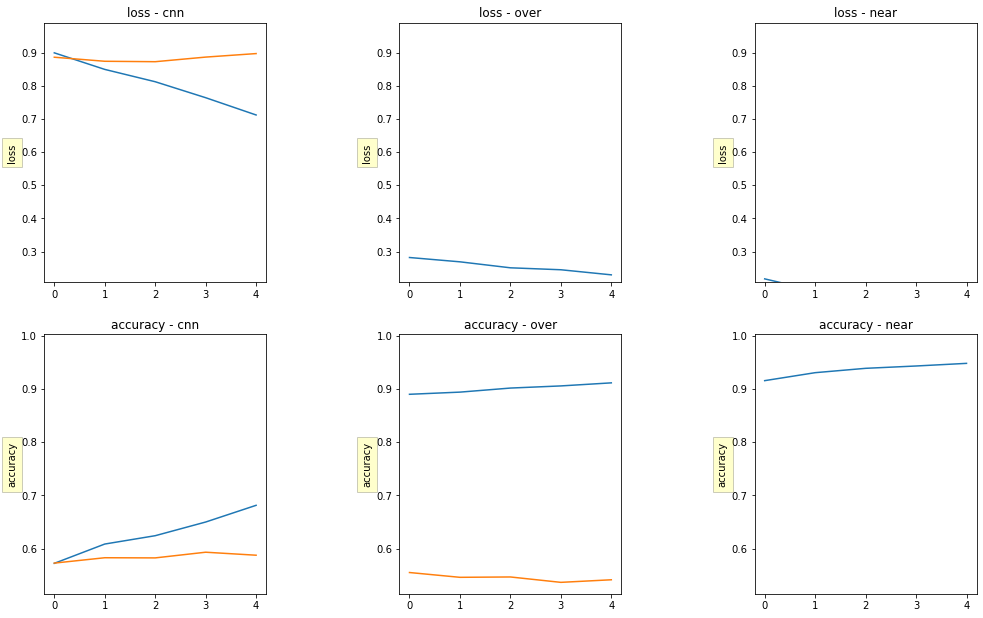

In [64]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_over_history,
          cnn_near_history,
          model_1_name='cnn',
          model_2_name='over',
          model_3_name='near')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# RNN

In [65]:
def build_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=True):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

python(92722) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


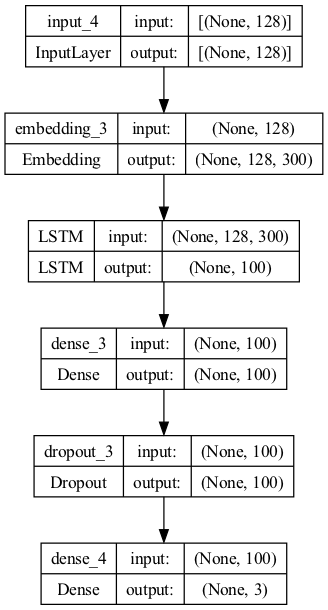

In [66]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3
rnn_model = build_rnn_model(num_classes,
                            rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [67]:
rnn_history = rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
843/843 [==============================] - 57s 65ms/step - loss: 0.9680 - accuracy: 0.4414 - val_loss: 0.9589 - val_accuracy: 0.4437
Epoch 2/5
843/843 [==============================] - 53s 63ms/step - loss: 0.9636 - accuracy: 0.4442 - val_loss: 0.9598 - val_accuracy: 0.4437
Epoch 3/5
843/843 [==============================] - 54s 64ms/step - loss: 0.9626 - accuracy: 0.4467 - val_loss: 0.9590 - val_accuracy: 0.4496
Epoch 4/5
843/843 [==============================] - 55s 66ms/step - loss: 0.9626 - accuracy: 0.4444 - val_loss: 0.9593 - val_accuracy: 0.4496
Epoch 5/5
843/843 [==============================] - 60s 71ms/step - loss: 0.9622 - accuracy: 0.4439 - val_loss: 0.9601 - val_accuracy: 0.4437


In [101]:
rnn_score = cnn_model.evaluate(train_input,dummy_train_y)
print("%s: %.2f%%" % (rnn_model.metrics_names[1], rnn_score[1]*100))

y_pred = rnn_model.predict(test_input, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(t_test_labels, y_pred_bool))

843/843 [==============================] - 14s 16ms/step - loss: 0.1060 - accuracy: 0.9634
accuracy: 96.34%
53/53 [==============================] - 4s 48ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1516
           1       0.00      0.00      0.00      1496
           2       0.11      1.00      0.19       360

    accuracy                           0.11      3372
   macro avg       0.04      0.33      0.06      3372
weighted avg       0.01      0.11      0.02      3372



/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
rnn_over_history = rnn_model.fit(train_over_input,
                          dummy_train_over_y,
                          validation_data=(test_over_input, dummy_valid_over_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
1135/1135 [==============================] - 80s 70ms/step - loss: 1.0017 - accuracy: 0.4323 - val_loss: 1.0039 - val_accuracy: 0.4310
Epoch 2/5
1135/1135 [==============================] - 73s 65ms/step - loss: 1.0016 - accuracy: 0.4287 - val_loss: 1.0036 - val_accuracy: 0.4310
Epoch 3/5
1135/1135 [==============================] - 74s 65ms/step - loss: 1.0017 - accuracy: 0.4295 - val_loss: 1.0039 - val_accuracy: 0.4270
Epoch 4/5
1135/1135 [==============================] - 73s 65ms/step - loss: 1.0013 - accuracy: 0.4309 - val_loss: 1.0036 - val_accuracy: 0.4310
Epoch 5/5
1135/1135 [==============================] - 74s 65ms/step - loss: 1.0009 - accuracy: 0.4313 - val_loss: 1.0034 - val_accuracy: 0.4270


In [69]:
rnn_near_history = rnn_model.fit(train_near_input,
                          dummy_train_near_y,
                          validation_data=(test_near_input, dummy_valid_near_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
272/272 [==============================] - 17s 64ms/step - loss: 1.1158 - accuracy: 0.3332 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 2/5
272/272 [==============================] - 18s 65ms/step - loss: 1.1028 - accuracy: 0.3341 - val_loss: 1.1027 - val_accuracy: 0.3333
Epoch 3/5
272/272 [==============================] - 19s 72ms/step - loss: 1.1040 - accuracy: 0.3279 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 4/5
272/272 [==============================] - 19s 69ms/step - loss: 1.1008 - accuracy: 0.3341 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 5/5
272/272 [==============================] - 19s 69ms/step - loss: 1.1009 - accuracy: 0.3340 - val_loss: 1.0987 - val_accuracy: 0.3333


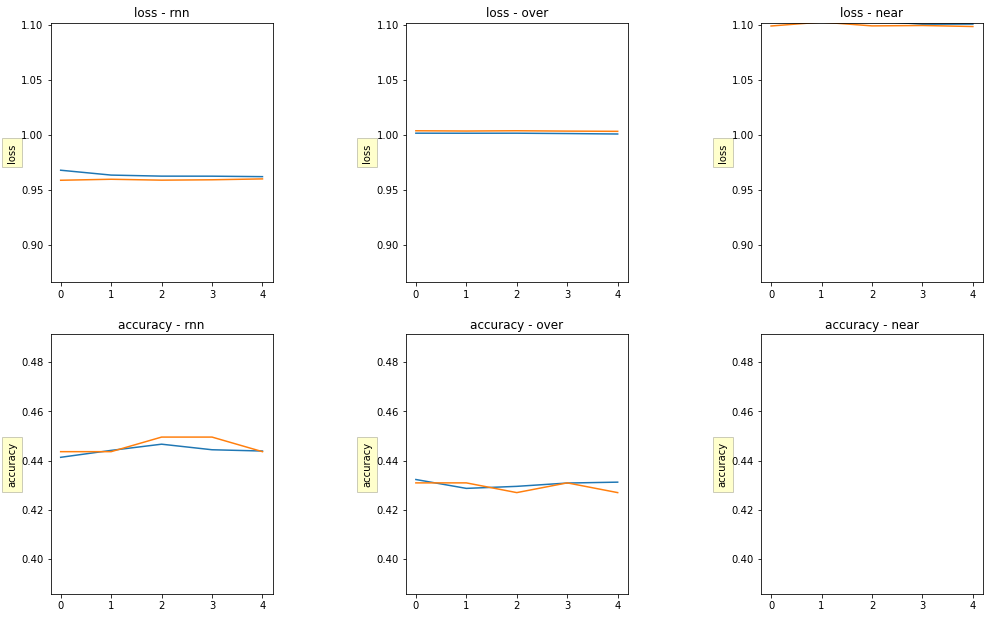

In [70]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          rnn_history,
          rnn_over_history,
          rnn_near_history,
          model_1_name='rnn',
          model_2_name='over',
          model_3_name='near')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# Stacked RNN

In [71]:
def build_stacked_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the stacked one
    #first one is called sequence output and change return_seq = True
    rnn_seq_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=True, return_state=False, name='LSTM1')\
        (rnn_embeddings)
    
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM2')\
        (rnn_seq_output) # calc the seq here
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

In [72]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3

stack_rnn_model = build_stacked_rnn_model(num_classes, 
                                          rnn_dim,
                                            dense_layer_dims,
                                            dropout_rate,
                                            embeddings_trainable=False)

In [73]:
stack_rnn_history = stack_rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
843/843 [==============================] - 100s 115ms/step - loss: 0.9686 - accuracy: 0.4441 - val_loss: 0.9620 - val_accuracy: 0.4437
Epoch 2/5
843/843 [==============================] - 94s 111ms/step - loss: 0.9635 - accuracy: 0.4435 - val_loss: 0.9592 - val_accuracy: 0.4437
Epoch 3/5
843/843 [==============================] - 94s 112ms/step - loss: 0.9626 - accuracy: 0.4476 - val_loss: 0.9597 - val_accuracy: 0.4437
Epoch 4/5
843/843 [==============================] - 94s 111ms/step - loss: 0.9623 - accuracy: 0.4432 - val_loss: 0.9590 - val_accuracy: 0.4496
Epoch 5/5
843/843 [==============================] - 93s 111ms/step - loss: 0.9618 - accuracy: 0.4458 - val_loss: 0.9591 - val_accuracy: 0.4437


In [102]:
stack_rnn_score = stack_rnn_model.evaluate(train_input,dummy_train_y)
print("%s: %.2f%%" % (stack_rnn_model.metrics_names[1], stack_rnn_score[1]*100))

y_pred = stack_rnn_model.predict(test_input, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(t_test_labels, y_pred_bool))

843/843 [==============================] - 36s 42ms/step - loss: 1.1107 - accuracy: 0.1073
accuracy: 10.73%
53/53 [==============================] - 5s 74ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1516
           1       0.00      0.00      0.00      1496
           2       0.11      1.00      0.19       360

    accuracy                           0.11      3372
   macro avg       0.04      0.33      0.06      3372
weighted avg       0.01      0.11      0.02      3372



/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peeti_mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
stack_over_history = stack_rnn_model.fit(train_over_input,
                          dummy_train_over_y,
                          validation_data=(test_over_input, dummy_valid_over_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
1135/1135 [==============================] - 138s 120ms/step - loss: 1.0020 - accuracy: 0.4276 - val_loss: 1.0036 - val_accuracy: 0.4310
Epoch 2/5
1135/1135 [==============================] - 138s 122ms/step - loss: 1.0015 - accuracy: 0.4292 - val_loss: 1.0033 - val_accuracy: 0.4310
Epoch 3/5
1135/1135 [==============================] - 148s 130ms/step - loss: 1.0015 - accuracy: 0.4262 - val_loss: 1.0037 - val_accuracy: 0.4270
Epoch 4/5
1135/1135 [==============================] - 168s 148ms/step - loss: 1.0014 - accuracy: 0.4320 - val_loss: 1.0036 - val_accuracy: 0.4310
Epoch 5/5
1135/1135 [==============================] - 151s 133ms/step - loss: 1.0011 - accuracy: 0.4321 - val_loss: 1.0035 - val_accuracy: 0.4270


In [75]:
stack_near_history = stack_rnn_model.fit(train_near_input,
                          dummy_train_near_y,
                          validation_data=(test_near_input, dummy_valid_near_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
272/272 [==============================] - 36s 132ms/step - loss: 1.1116 - accuracy: 0.3305 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/5
272/272 [==============================] - 34s 126ms/step - loss: 1.1024 - accuracy: 0.3387 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 3/5
272/272 [==============================] - 33s 122ms/step - loss: 1.1014 - accuracy: 0.3394 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 4/5
272/272 [==============================] - 38s 138ms/step - loss: 1.1019 - accuracy: 0.3372 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 5/5
272/272 [==============================] - 41s 152ms/step - loss: 1.1010 - accuracy: 0.3352 - val_loss: 1.0991 - val_accuracy: 0.3333


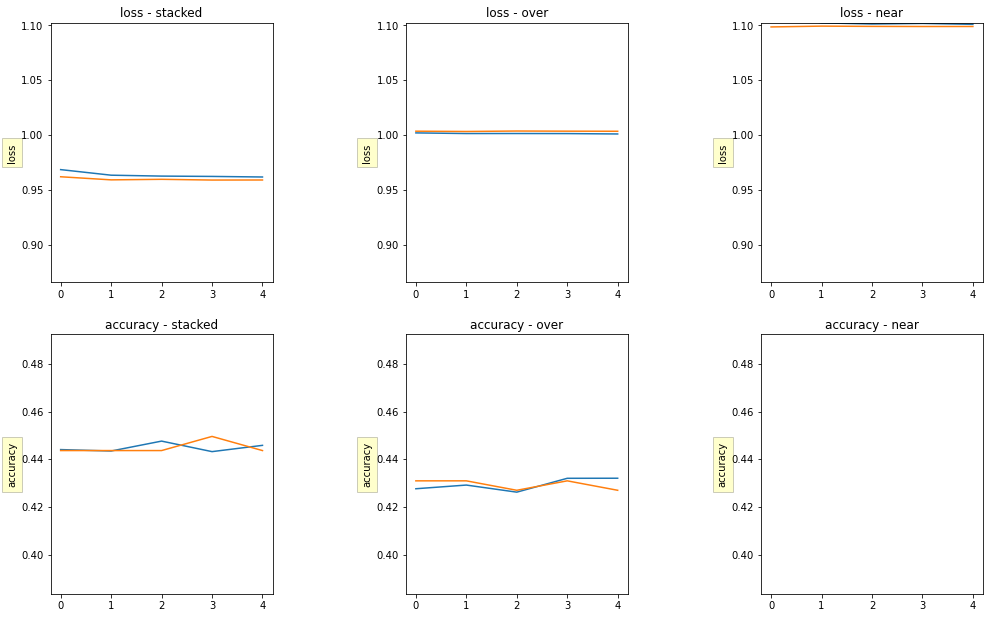

In [76]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          stack_rnn_history,
          stack_over_history,
          stack_near_history,
          model_1_name='stacked',
          model_2_name='over',
          model_3_name='near')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# BiDirectional RNN

In [77]:
def build_bidirectional_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the Bidirectional one
    #first one is called sequence output and change return_seq = True
    rnn_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM1'))\
        (rnn_embeddings)
    
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  
                      metrics=['accuracy'])
    return rnn_model

In [78]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3

bi_rnn_model = build_bidirectional_rnn_model(num_classes,
                                             rnn_dim,
                                            dense_layer_dims,
                                            dropout_rate,
                                            embeddings_trainable=False)

In [79]:
bi_rnn_history = bi_rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
843/843 [==============================] - 92s 106ms/step - loss: 0.8965 - accuracy: 0.5744 - val_loss: 0.8879 - val_accuracy: 0.5700
Epoch 2/5
843/843 [==============================] - 91s 108ms/step - loss: 0.8662 - accuracy: 0.5994 - val_loss: 0.8800 - val_accuracy: 0.5777
Epoch 3/5
843/843 [==============================] - 91s 108ms/step - loss: 0.8531 - accuracy: 0.6048 - val_loss: 0.8732 - val_accuracy: 0.5807
Epoch 4/5
843/843 [==============================] - 91s 108ms/step - loss: 0.8462 - accuracy: 0.6086 - val_loss: 0.8706 - val_accuracy: 0.5833
Epoch 5/5
843/843 [==============================] - 91s 108ms/step - loss: 0.8356 - accuracy: 0.6142 - val_loss: 0.8818 - val_accuracy: 0.5845


In [103]:
bi_rnn_score = bi_rnn_model.evaluate(train_input,dummy_train_y)
print("%s: %.2f%%" % (bi_rnn_model.metrics_names[1], bi_rnn_score[1]*100))

y_pred = bi_rnn_model.predict(test_input, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(t_test_labels, y_pred_bool))

843/843 [==============================] - 41s 49ms/step - loss: 0.4014 - accuracy: 0.8530
accuracy: 85.30%
53/53 [==============================] - 4s 67ms/step
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1516
           1       0.52      0.52      0.52      1496
           2       0.20      0.23      0.21       360

    accuracy                           0.50      3372
   macro avg       0.43      0.43      0.43      3372
weighted avg       0.50      0.50      0.50      3372



In [81]:
bi_over_history = bi_rnn_model.fit(train_over_input,
                          dummy_train_over_y,
                          validation_data=(test_over_input, dummy_valid_over_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
1135/1135 [==============================] - 140s 123ms/step - loss: 0.4936 - accuracy: 0.7857 - val_loss: 1.4905 - val_accuracy: 0.5303
Epoch 2/5
1135/1135 [==============================] - 136s 120ms/step - loss: 0.4459 - accuracy: 0.8122 - val_loss: 1.5444 - val_accuracy: 0.5167
Epoch 3/5
1135/1135 [==============================] - 136s 120ms/step - loss: 0.4080 - accuracy: 0.8262 - val_loss: 1.6106 - val_accuracy: 0.5108
Epoch 4/5
1135/1135 [==============================] - 135s 119ms/step - loss: 0.3666 - accuracy: 0.8436 - val_loss: 1.7623 - val_accuracy: 0.5101
Epoch 5/5
1135/1135 [==============================] - 138s 121ms/step - loss: 0.3341 - accuracy: 0.8595 - val_loss: 2.0345 - val_accuracy: 0.5101


In [82]:
bi_near_history = bi_rnn_model.fit(train_near_input,
                          dummy_train_near_y,
                          validation_data=(test_near_input, dummy_valid_near_y),
                          batch_size=32,
                          epochs=5
                          )

Epoch 1/5
272/272 [==============================] - 32s 119ms/step - loss: 0.2862 - accuracy: 0.8853 - val_loss: 2.6590 - val_accuracy: 0.4259
Epoch 2/5
272/272 [==============================] - 32s 119ms/step - loss: 0.2294 - accuracy: 0.9107 - val_loss: 2.8907 - val_accuracy: 0.4426
Epoch 3/5
272/272 [==============================] - 32s 118ms/step - loss: 0.1895 - accuracy: 0.9255 - val_loss: 3.1071 - val_accuracy: 0.4407
Epoch 4/5
272/272 [==============================] - 32s 119ms/step - loss: 0.1471 - accuracy: 0.9411 - val_loss: 3.4256 - val_accuracy: 0.4426
Epoch 5/5
272/272 [==============================] - 33s 120ms/step - loss: 0.1364 - accuracy: 0.9486 - val_loss: 3.7995 - val_accuracy: 0.4324


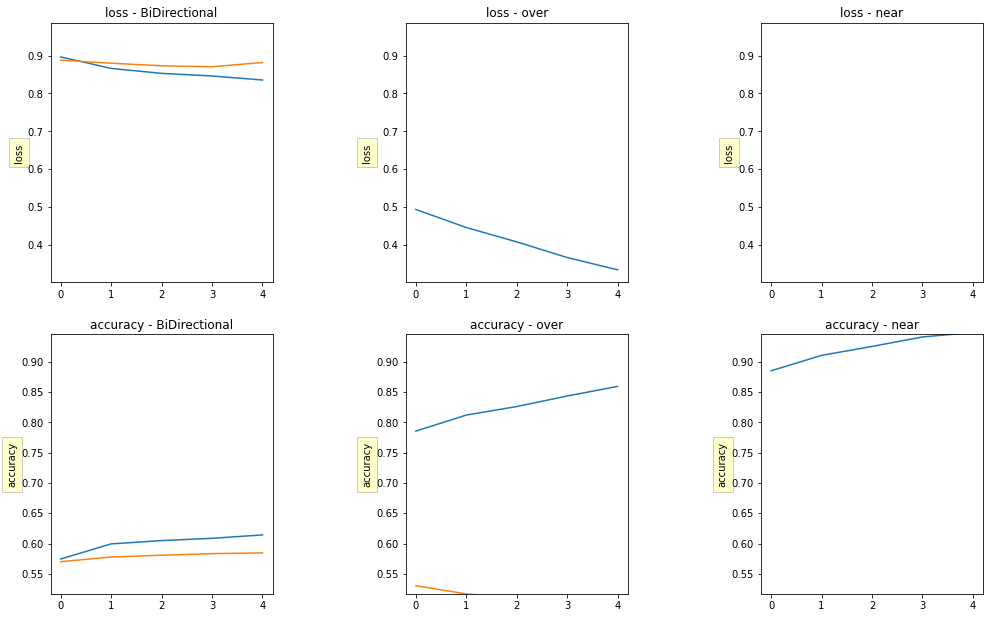

In [83]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          bi_rnn_history,
          bi_over_history,
          bi_near_history,
          model_1_name='BiDirectional',
          model_2_name='over',
          model_3_name='near')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()